In [2]:
from thesispy.elastix_wrapper.runner import run
from thesispy.elastix_wrapper.parameters import Parameters, Collection
from thesispy.definitions import *

from pathlib import Path

2023-03-24 11:52:43,465 - Runner - INFO - Running elastix in: ../output/1679655163_learn_2_gomea_464646



elastix is started at Fri Mar 24 11:52:43 2023.

which elastix:   /home/joasiee/Documents/projects/elastix/build/Release/bin/elastix
  elastix version: 5.1.0
  Git revision SHA: 5a2f18be46d9ee0029ad5c3b7690fde1020dc9f4
  Git revision date: Thu Mar 23 21:42:01 2023 +0100
  Build date: Mar 23 2023 21:42:18
  Compiler: GCC version 12.2.1 20230201
  Memory address size: 64-bit
  CMake version: 3.26.0
  ITK version: 5.3.0

Command-line arguments: 
  -p ../output/1679655163_learn_2_gomea_464646/params_1.txt -f /home/joasiee/Documents/projects/instances/learn/scans/02_Fixed.nii.gz -m /home/joasiee/Documents/projects/instances/learn/scans/02_Moving.nii.gz -out ../output/1679655163_learn_2_gomea_464646/out -threads 6 -fMask /home/joasiee/Documents/projects/instances/learn/masks/02_Fixed.nii.gz

elastix runs at: archlinux
  Linux 6.1.20-1-lts (x64), #1 SMP PREEMPT_DYNAMIC Fri, 17 Mar 2023 13:31:00 +0000
  with 31842 MB memory, and 10 cores @ 4427 MHz.
-------------------------------------------

2023-03-24 11:53:24,766 - Validation - INFO - Calculating validation metrics for LEARN:
2023-03-24 11:53:24,766 - Validation - INFO - TRE: 14.862233870827751
2023-03-24 11:53:24,767 - Validation - INFO - Bending Energy: 0.47
2023-03-24 11:53:24,866 - Validation - INFO - Jacobian min,max: -1.7281983657201283, 3.05851908110497
/home/joasiee/Documents/projects/elastix/experiments/thesispy/experiments/validation.py:892: RuntimeWarning: invalid value encountered in log
  sdlogj = (np.log(jac_det) * result.instance.mask).std()
computing bending energy: 100%|██████████| 47621/47621.0 [00:03<00:00, 12347.38it/s]
2023-03-24 11:53:28,801 - Validation - INFO - SDLogJ: nan
2023-03-24 11:53:28,801 - Validation - INFO - Dice Similarity: 0.8616
2023-03-24 11:53:28,802 - Validation - INFO - Bending Energy (crude): 1643.5943
2023-03-24 11:53:38,938 - Validation - INFO - Validation metrics calculated in 14.17s
2023-03-24 11:53:38,938 - Runner - INFO - Run ended. It took 55.4731 seconds
libpng warning: i

/home/joasiee/.local/bin/vv


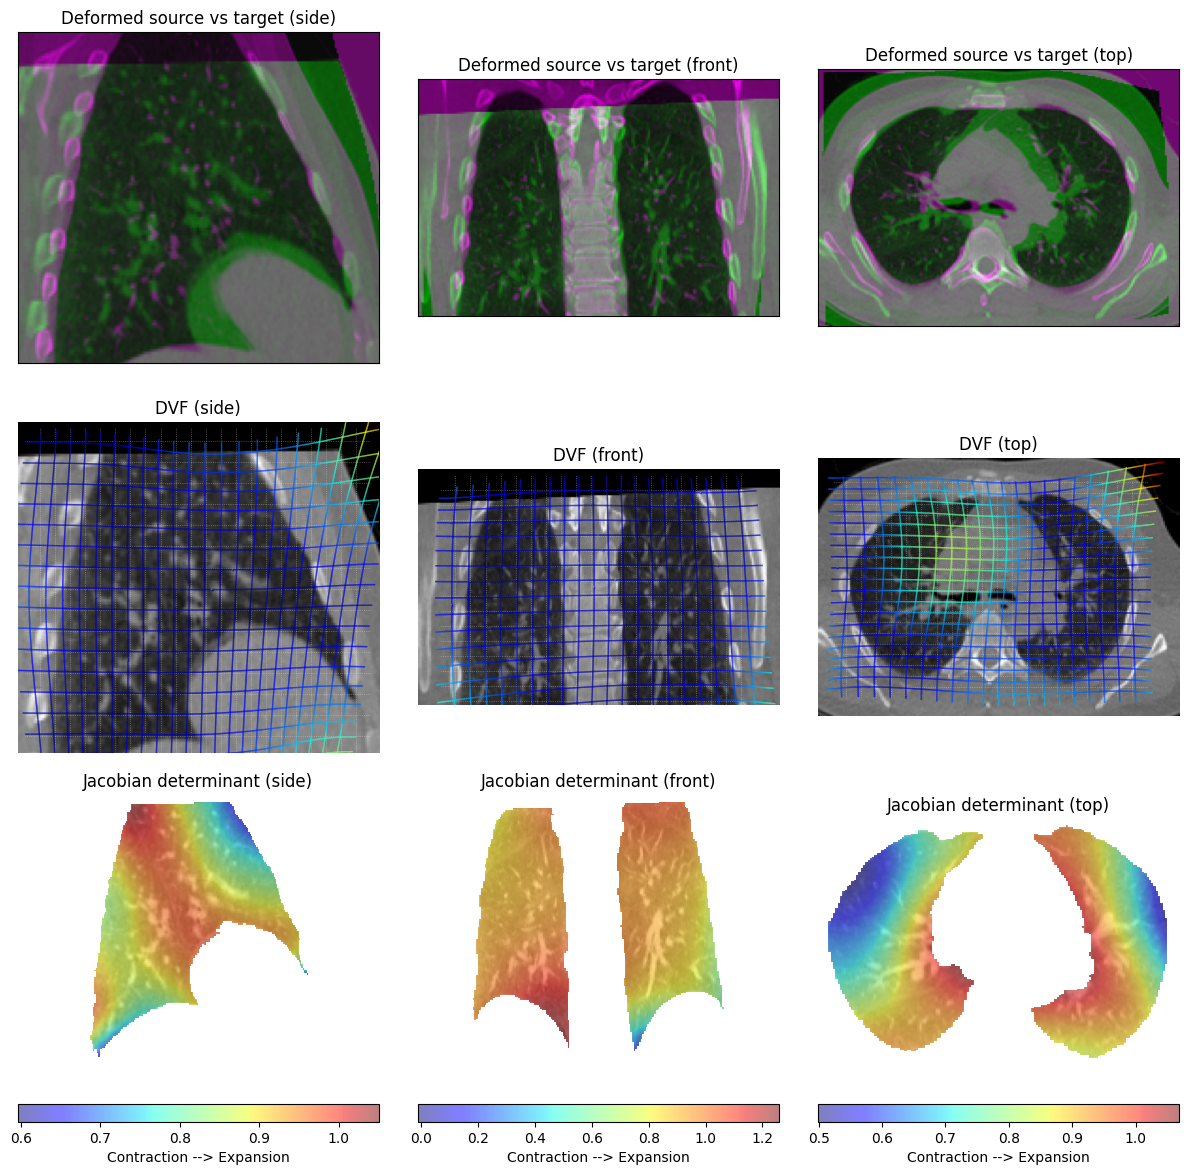

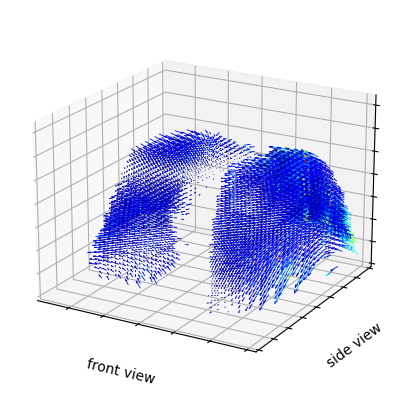

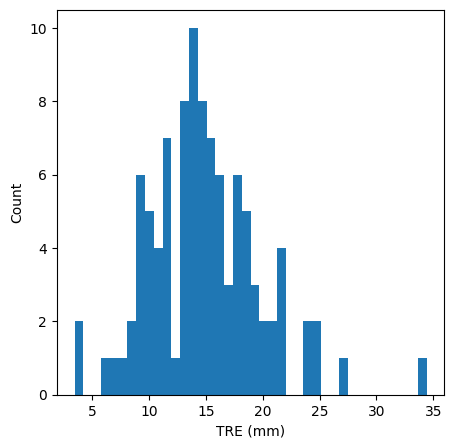

In [3]:
params = (
    Parameters.from_base(use_mask=True, metric="AdvancedNormalizedCorrelation")
    .gomea(hybrid=True, asgd_iterations_offset=0)
    .multi_resolution(1, r_sched=[6])
    .stopping_criteria(10)
    .instance(Collection.LEARN, 2)
)
result = run(params, Path("../output/" + str(params)), suppress_stdout=False, visualize=True, validate=True)